### CNN ASSIGNMENT

## Q1 - Part A: Data Understanding and Preprocessing

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

c:\python\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
IMAGE_SIZE = 256
TARGET_SIZE = 150
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

c:\python\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\asus\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2


In [4]:
import os
os.listdir(path)

['seg_pred', 'seg_test', 'seg_train']

In [5]:
train_path = os.path.join(path,"seg_train","seg_train")
test_path  = os.path.join(path,"seg_test","seg_test")
pred_path =  os.path.join(path,"seg_pred")

In [6]:
train_path

'C:\\Users\\asus\\.cache\\kagglehub\\datasets\\puneet6060\\intel-image-classification\\versions\\2\\seg_train\\seg_train'

In [7]:
test_path

'C:\\Users\\asus\\.cache\\kagglehub\\datasets\\puneet6060\\intel-image-classification\\versions\\2\\seg_test\\seg_test'

In [8]:
pred_path

'C:\\Users\\asus\\.cache\\kagglehub\\datasets\\puneet6060\\intel-image-classification\\versions\\2\\seg_pred'

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

pred_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pred_path,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


In [10]:
class_name = train_ds.class_names
class_name

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

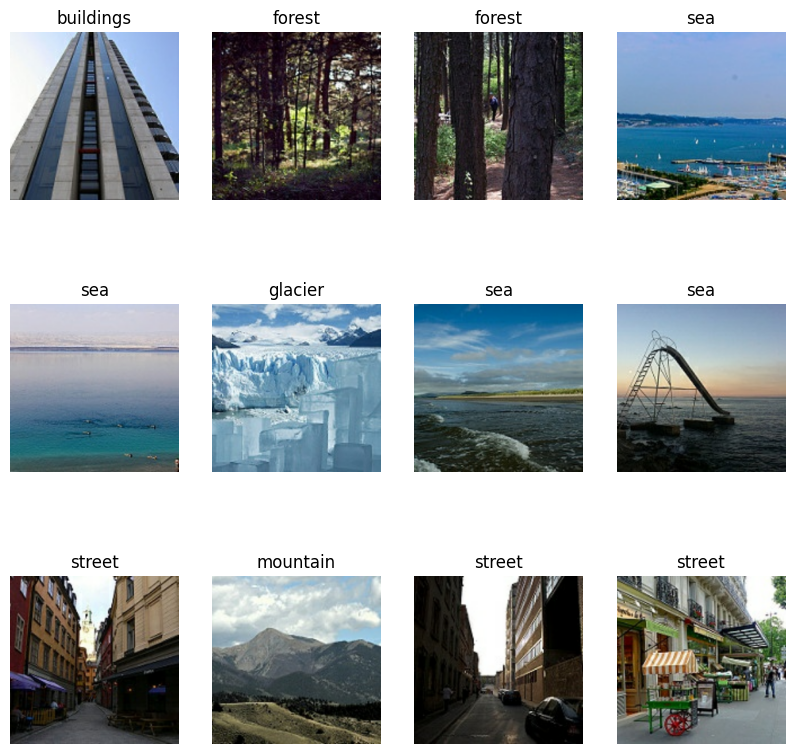

In [11]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[label_batch[i]])
    plt.axis("off")

RESIZE AND NORMALIZE

In [12]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),   # ✅ NOT vertical
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

In [15]:
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
pred_ds   = pred_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

In [16]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)

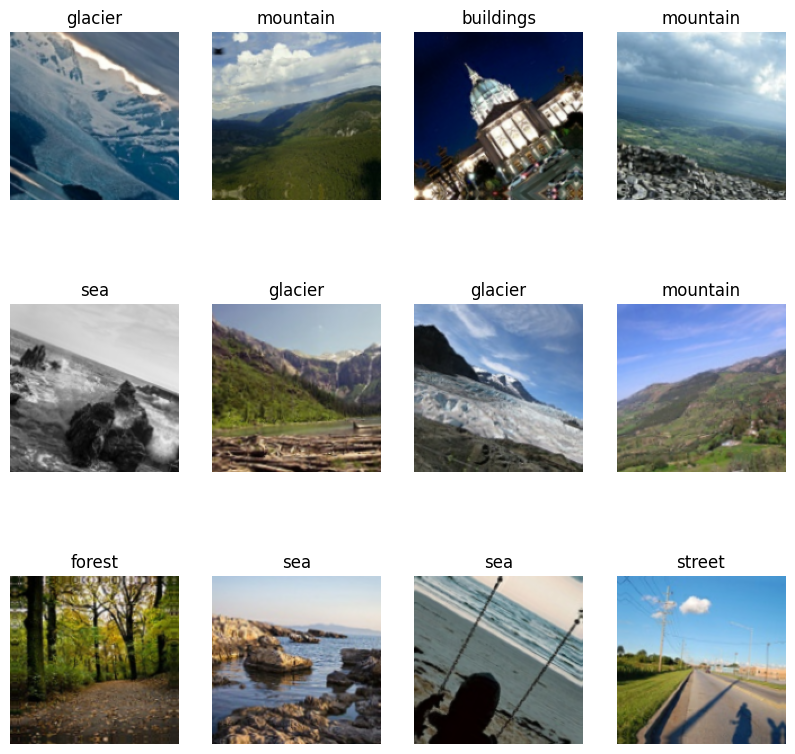

In [17]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy())
    plt.title(class_name[label_batch[i]])
    plt.axis("off")

### Part B: CNN Model Development

In [18]:
input_shape = (TARGET_SIZE,TARGET_SIZE,CHANNELS)
n_classes =  6

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])


model.build(input_shape= (None,TARGET_SIZE,TARGET_SIZE,CHANNELS))

c:\python\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
for images, labels in train_ds.take(1):
    print(images.shape)


(32, 150, 150, 3)


In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      # stop based on validation loss
    patience=5,              # wait 5 epochs before stopping
    restore_best_weights=True,  # load best model weights
    min_delta=0.001          # minimum improvement required
)


In [23]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 106s 236ms/step - accuracy: 0.5009 - loss: 1.2545 - val_accuracy: 0.6553 - val_loss: 0.9547
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 101s 229ms/step - accuracy: 0.6158 - loss: 1.0201 - val_accuracy: 0.6917 - val_loss: 0.8580
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 103s 234ms/step - accuracy: 0.6489 - loss: 0.9404 - val_accuracy: 0.6953 - val_loss: 0.8263
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 236ms/step - accuracy: 0.6699 - loss: 0.8933 - val_accuracy: 0.7250 - val_loss: 0.7584
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 103s 232ms/step - accuracy: 0.6865 - loss: 0.8543 - val_accuracy: 0.7283 - val_loss: 0.7350
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 102s 232ms/step - accuracy: 0.6980 - loss: 0.8287 - val_accuracy: 0.7470 - val_loss: 0.6997
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 102s 231ms/step - accuracy: 0.7155 - loss: 0.7941 - val_accuracy: 0.7533 - val_loss: 0.6934
Epoch 8/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 102s 230ms/step - accuracy: 0.7230 -

In [24]:
scores = model.evaluate(test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8070 - loss: 0.5381


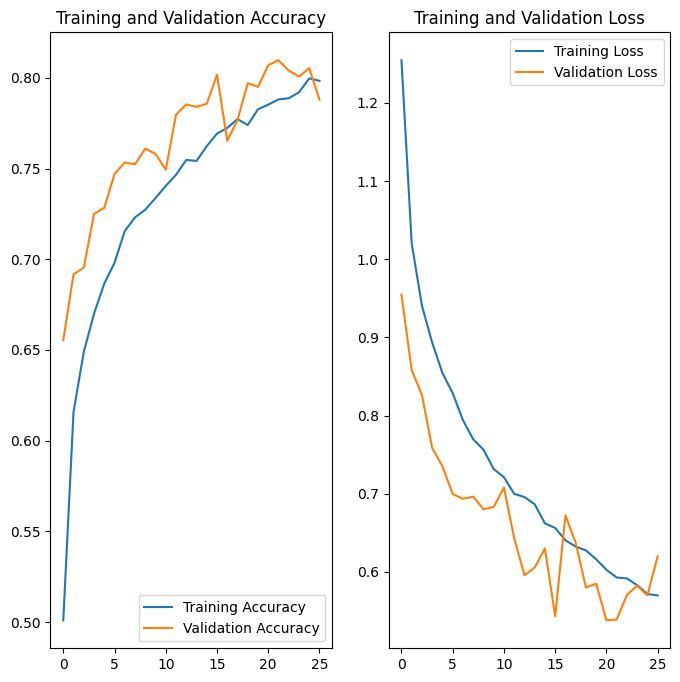

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))   # number of epochs actually trained

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: forest
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
predicted label: forest


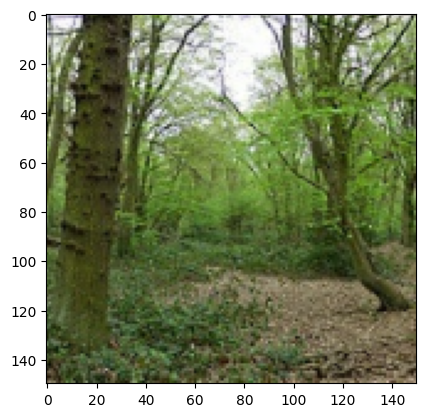

In [26]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[1].numpy()
    first_label = labels_batch[1].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[1])])

Actual label: forest
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted: forest


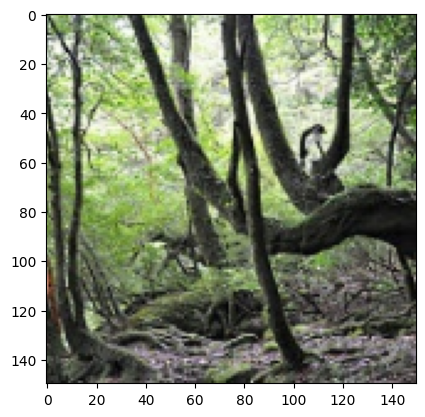

In [27]:
test_list = list(test_ds.unbatch())
image_15, label_15 = test_list[40]   # 0-based index  11

image_15 = image_15.numpy()
label_15 = label_15.numpy()

plt.imshow(image_15)
print("Actual label:", class_name[label_15])

prediction = model.predict(tf.expand_dims(image_15, axis=0))
print("Predicted:", class_name[np.argmax(prediction)])


In [28]:
model.save("nature_model.h5")

In [29]:
loaded_model = tf.keras.models.load_model("nature_model.h5")

### Part C: Model Evaluation and Interpretation

In [30]:
import numpy as np

y_true = np.concatenate([labels for images, labels in test_ds])
y_pred = np.argmax(model.predict(test_ds), axis=1)


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step


In [31]:
# accuracy

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true,y_pred)
print(accuracy)

0.16766666666666666


In [33]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, average="weighted")
print("F1-score:", f1)


F1-score: 0.16770459553219538


In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


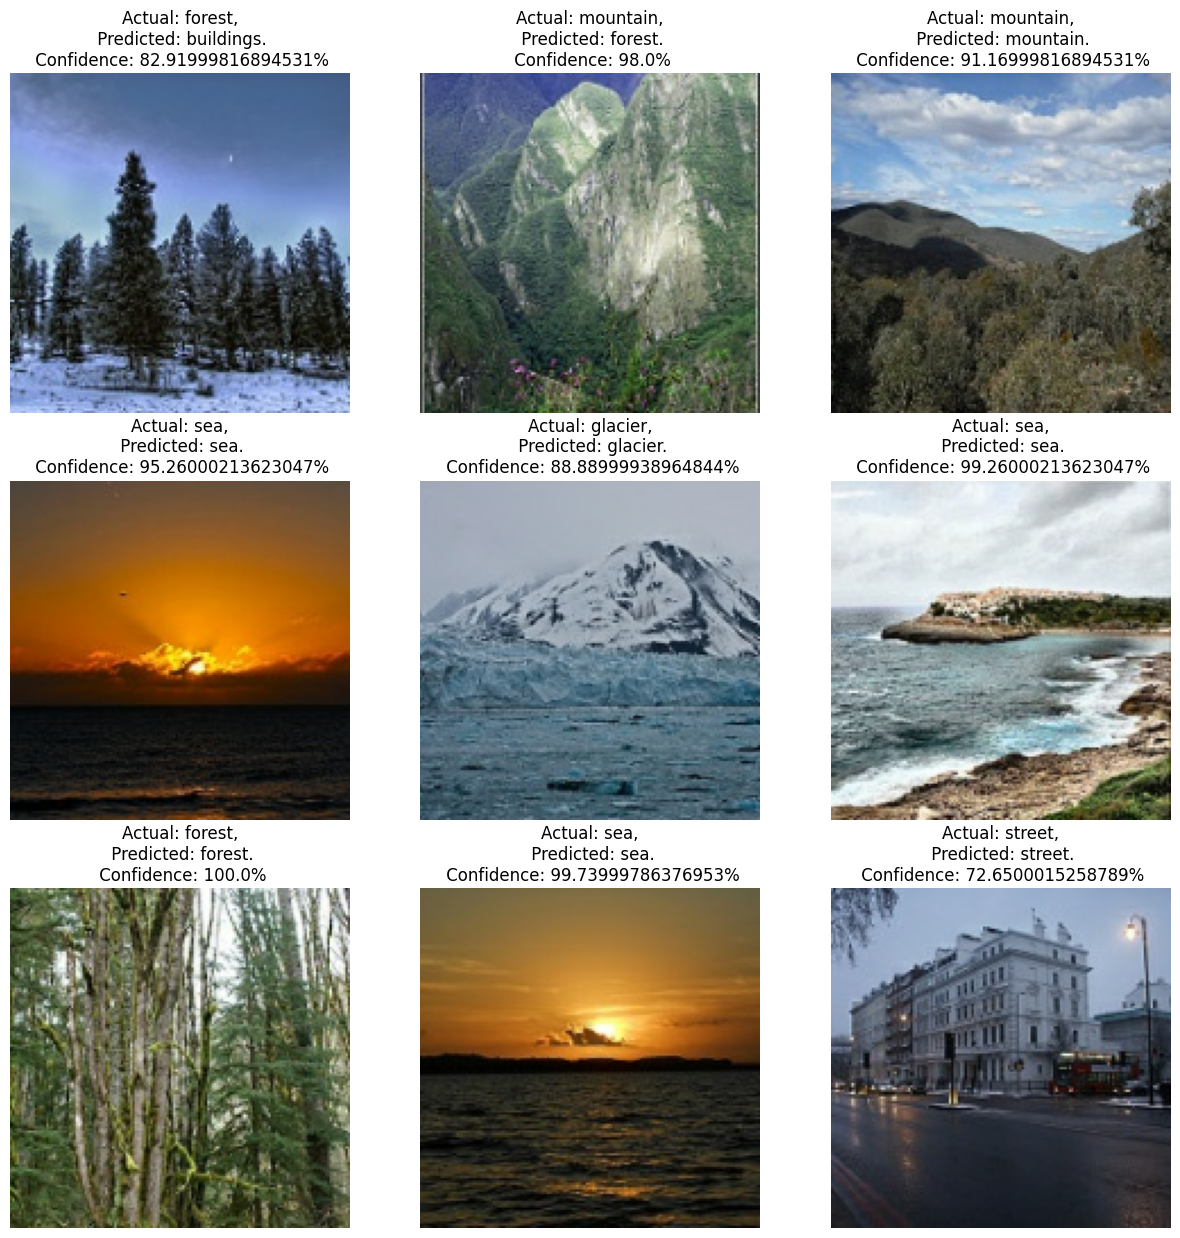

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
